# CMPINF 0010 Final Project
---
In this final project, our team has been tasked to find the best neighborhood in Pittsburgh through our own metrics.

## Metric 1 - Arrest/Crime Data
---
One of the first metrics that our group thought of was safety, no matter what the benefits of a neighborhood are, if there is a high crime rate

<AxesSubplot:>

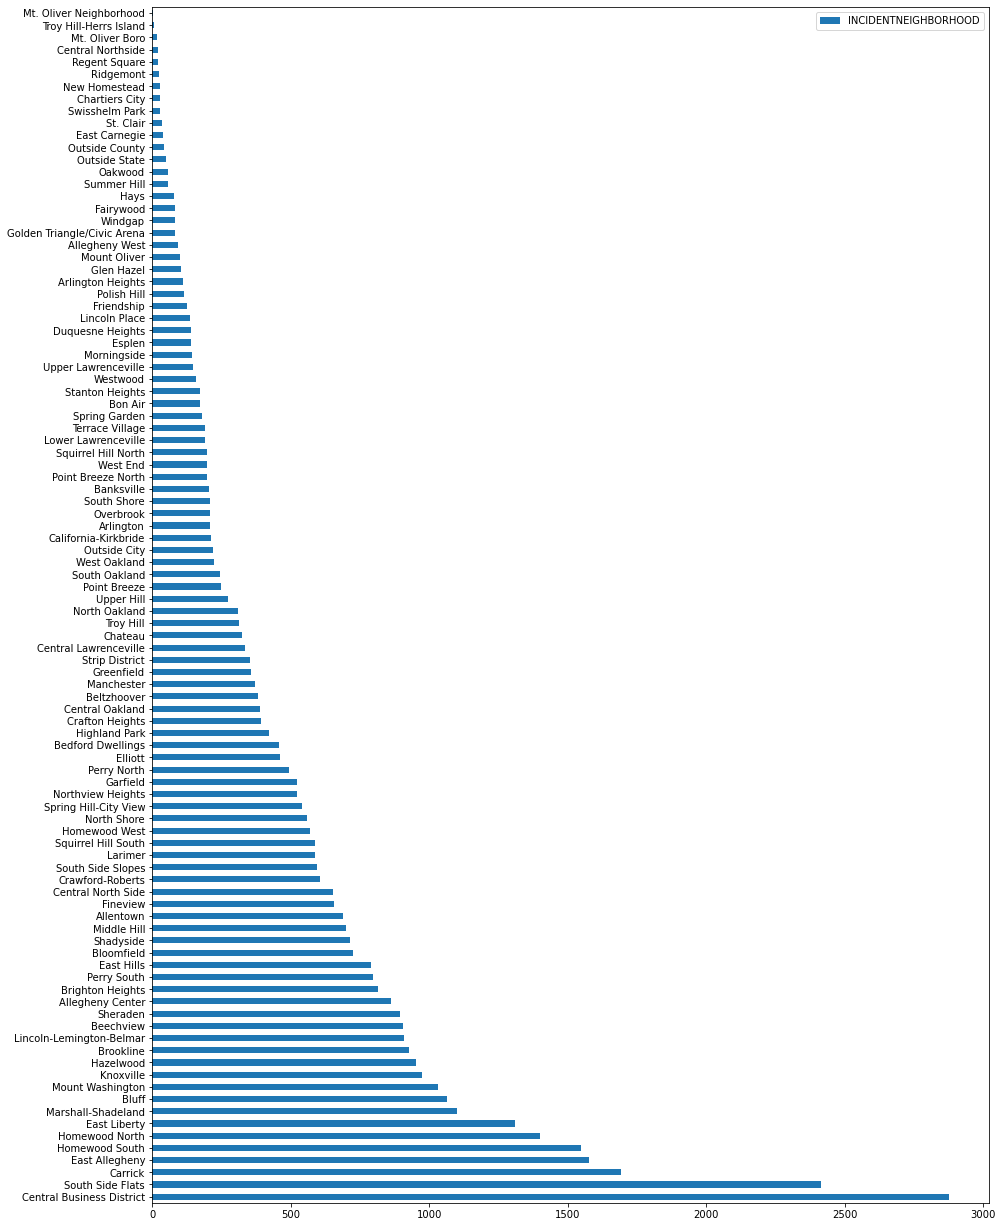

In [59]:
import pandas as pd
import geopandas
%matplotlib inline

arrests = pd.read_csv("Arrests.csv")

locations = pd.DataFrame(arrests["INCIDENTNEIGHBORHOOD"].value_counts())
#may want to sort by descending

locations.plot.barh(figsize = (15, 22))

<AxesSubplot:>

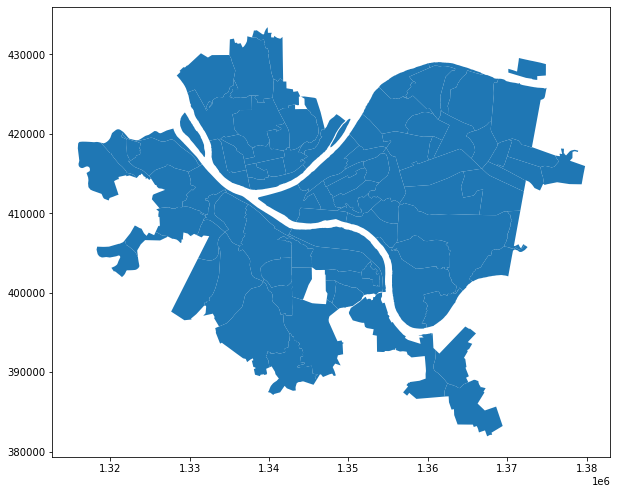

In [64]:
#YOU CAN ALL USE THE NEIGHBORHOODS MAP AS A BASE IF YOU WANT TO PLOT
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods.plot(figsize = (10,10))

In [65]:
neighborhoods[['hood','area','perimeter','geometry']]

,hood,area,perimeter,geometry
0,Chateau,10688264.0,80995.806272,"POLYGON ((1334127.196 418284.606, 1334150.461 ..."
1,Summer Hill,12232021.0,80995.806272,"POLYGON ((1339850.631 432956.640, 1339858.400 ..."
2,Northview Heights,8739570.0,80995.806272,"POLYGON ((1341778.327 426695.719, 1341780.150 ..."
3,Spring Hill-City View,17550592.0,80995.806272,"POLYGON ((1343276.368 423702.914, 1343276.483 ..."
4,Perry South,25220622.0,80995.806272,"POLYGON ((1338684.967 424859.918, 1338646.933 ..."
...,...,...,...,...
85,Overbrook,23393388.0,198927.416142,"POLYGON ((1342891.744 394551.341, 1342898.949 ..."
86,Chartiers City,3683600.5,198927.416142,"POLYGON ((1323234.375 419070.000, 1323255.578 ..."
87,Esplen,6409852.5,198927.416142,"POLYGON ((1328174.017 420097.302, 1328211.790 ..."
88,Ridgemont,10278895.0,198927.416142,"POLYGON ((1332686.375 409054.375, 1332703.750 ..."


## Metric 2 - 
---

## Metric 3 - 
---

## Conclusion
---